# IMOS/AODN Long Time Series Products

## Background

IMOS support the Australian National Mooring Network, which is a facility that deploys and maintains moored oceanographic instruments all around Australia. The facility is independently run by five sub-facilities that are responsible for the QA/QC of the data.


![ANMR at AODN](images/ANMN_portal.png)



The data is stored in netCDF CF compliant files, one file per instrument per deployment per site. The files are accessible through AODN THREDDS server.


![AODN THREDDS](images/AODN_THREDDS.png)

## The Problem

Depending on the user, some difficulties in accessing and processing the files could reduce the usability of the data: 

- netCDF files are not the prefered format for biologist
- the data is scattered across multiple files
- there are different levels of QC

So, to generate a long time series of for example, Temperature for one site, requires a relatively high level of expertise.

IMOS has decided to invest in the generation of a more "user friendly" products in order to facilitate the usability of the data by non-expert users --> LTSP series

- Aggregated time series: ONE variable from ALL instruments at ONE site
- Hourly time series: ALL variables from ALL instruments at ONE site, binned to 1hr fixed interval
- Gridded time series: ONE variable from ALL instruments at ONE sites binned to 1hr bins and 1m depth bins (more for the deep water moorings)




## The Format

To aggregate all instruments that has been deployed over the time at different depth requires a particular netCDF structure: [Indexed Ragged Array Representation](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#_indexed_ragged_array_representation). 

This representation breaks the standard "rectangular" structure that has TIME as a common dimension with another structure that is indexed by "INSTRUMENT" and has "OBSERVATION" as a common dimension. `TIME` is now a variable in the file.


![indexed ragged array representation](images/ragged_array.png)


 This format have some pros and cons:
 
 PROS:
 - all values are in one single file.
 
 
 CONS: 
 - Not having `TIME` as a dimension require and understanding of the format and some "advanced" techniques to manipulate the data
 

## The Hourly time series: a working example


1. How to generate the product
2. How to use the product



## Tools

The tools used to aggregated the files are normally designed for AODN internal use, i.e. to be included in the production pipeline. However they could also be ran in the command line. 

Normally it require: 
- the site code, in standard IMOS nomenclature
- the variable name (in the case of indiviual variable aggregation
- a path where to store the result
- a QC flags list to filter the data to be aggregated, and
- a list of source file names or URLs

The next tool allows you to get the file URL from the AODN geoserver


### geoserverCatalog

This tool allows you to get the URL of the individual files according to many filtering criteria. It could be used in th a command line at it will return a list of URLs. Redirect the output to a text file for further use.

```
python geoserverCatalog.py --help
usage: geoserverCatalog.py [-h] [-var VARNAME] [-site SITE] [-ft FEATURETYPE]
                           [-fv FILEVERSION] [-ts TIMESTART] [-te TIMEEND]
                           [-dc DATACATEGORY] [-realtime REALTIME]
                           [-rm FILTEROUT [FILTEROUT ...]]

Get a list of urls from the AODN geoserver

optional arguments:
  -h, --help            show this help message and exit
  -var VARNAME          name of the variable of interest, like TEMP
  -site SITE            site code, like NRMMAI
  -ft FEATURETYPE       feature type, like timeseries
  -fv FILEVERSION       file version, like 1
  -ts TIMESTART         start time like 2015-12-01
  -te TIMEEND           end time like 2018-06-30
  -dc DATACATEGORY      data category like Temperature
  -realtime REALTIME    yes or no. If absent, all modes will be retrieved
  -rm FILTEROUT [FILTEROUT ...]
                        regex to filter out the url list. Case sensitive

```


You can also use it as a function: 

```
get_moorings_urls(varname=None, site=None, featuretype=None, fileversion=None, datacategory=None, realtime=None, timestart=None, timeend=None, filterout=None):
    """
    get moorings file URLS from AODN geoserver
    :param varname: name of the variable, like TEMP 
    :param site: ANMN site code, like NRSMAI
    :param featuretype: feature type, like timeseries
    :param fileversion: file version, like 1
    :param datacategory: data category like Temperature
    :param realtime: yes or no. If absent, all modes will be retrieved
    :param timestart: start time like 2015-12-01
    :param timeend: end time like 2018-06-30
    :param filterout: regex to filter out the url list. Case sensitive
    :return: list of URLs
    """

```

In [3]:
import geoserverCatalog as gc

site_code = 'NRSYON'
varname = 'TEMP'


## get FV01 TEMP from Yongala National Reference Station
files_YON_TEMP = gc.get_moorings_urls(varname=varname, site=site_code, fileversion=1)

print(len(files_YON_TEMP))

print(files_YON_TEMP[0])

432
http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Velocity/IMOS_ANMN-NRS_AETVZ_20080622T032430Z_NRSYON_FV01_NRSYON-0711-Aquadopp-Profiler-27.9_END-20080805T043930Z_C-20150225T034958Z.nc


you can "read" the file name according to the [IMOS file naming conventions](https://s3-ap-southeast-2.amazonaws.com/content.aodn.org.au/Documents/IMOS/Conventions/IMOS_NetCDF_Conventions.pdf). It contains the site name, time of the start and end of the deployment, the creation date, the type of product, the instrument, the depth and the file version. Also, there is a code that tells you what type of variables are in the file. 

Let's filter the file list by date. Say we want TEMP from NRSYON delayed mode from 2017, excluding "velocity" instruments:

In [4]:
file_YON_TEMP_2017 = gc.get_moorings_urls(varname='TEMP', site='NRSYON', fileversion=1, realtime='no', 
                                          filterout=['Velocity'], timestart='2017-01-01')



In [5]:
print(len(file_YON_TEMP_2017))
print(file_YON_TEMP_2017[0:10])

42
['http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/aggregated_timeseries/IMOS_ANMN-NRS_TZ_20080623_NRSYON_FV01_TEMP-aggregated-timeseries_END-20180509_C-20190819.nc', 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Biogeochem_timeseries/IMOS_ANMN-NRS_CFKSTUZ_20160924T072959Z_NRSYON_FV01_NRSYON-1609-SUB-SBE16plus-27.5_END-20170324T081459Z_C-20170920T000639Z.nc', 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Biogeochem_timeseries/IMOS_ANMN-NRS_CKOSTUZ_20160926T045927Z_NRSYON_FV01_NRSYON-1609-SRF-WQM-1.8_END-20170323T221059Z_C-20170920T000858Z.nc', 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170120T000949Z_NRSYON_FV01_Profile-SBE19plus_C-20170427T013349Z.nc', 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NRS/NRSYON/Biogeochem_profiles/IMOS_ANMN-NRS_CDEKOSTUZ_20170220T002601Z_NRSYON_FV01_Profile-SBE19plus_C-20170427T015441Z.nc', 'http://thredds.aodn.org.au/thredds/dodsC/IM

## The hourly product

Basically, the process is as follow:
1. Check the file for entry conditions: site_code, dates, depth, dimensions, etc
2. Discard out of the water records
3. Count QC flags -> indicator of the quality of the output
4. For each variable, resample the values into 1hr bins
    - Mean/median plus min, max, std, count
5. Add metadata
6. Save file

resampling: 

![burst average](images/BurstAveraging.png)


The file is open with xarray and the variables handled in pandas. This way more easy than working directly with the standard netCDF4 library (with some caveats...).
    
The resampling is done with the resample method in pandas (also existing in xarray, but 15 times slower).

Let's try with one file...
    

In [46]:
import datetime
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
## open a local file, but it could be an URL
## This is Water Quality Monitor that burst-sample many variables

file = 'data/IMOS_ANMN-QLD_CKOSTUZ_20090607T035930Z_GBRPPS_FV01_GBRPPS-0906-WQM-50.5_END-20091118T114530Z_C-20190725T031157Z.nc'

nc = xr.open_dataset(file)

nc

<xarray.Dataset>
Dimensions:                   (TIME: 961666)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2009-06-07T03:59:29.999998464 ... 2009-11-18T11:45:30.000001536
    LATITUDE                  float64 ...
    LONGITUDE                 float64 ...
    NOMINAL_DEPTH             float32 ...
Data variables:
    TIMESERIES                int32 ...
    CNDC                      (TIME) float32 ...
    CNDC_quality_control      (TIME) float32 ...
    TEMP                      (TIME) float32 ...
    TEMP_quality_control      (TIME) float32 ...
    PRES_REL                  (TIME) float32 ...
    PRES_REL_quality_control  (TIME) float32 ...
    DOX                       (TIME) float32 ...
    DOX_quality_control       (TIME) float32 ...
    CHLU                      (TIME) float32 ...
    CHLU_quality_control      (TIME) float32 ...
    TURB                      (TIME) float32 ...
    TURB_quality_control      (TIME) float32 ...
    DEPTH                     (TIME) fl

In [7]:
list(nc.variables)

['TIME',
 'TIMESERIES',
 'LATITUDE',
 'LONGITUDE',
 'NOMINAL_DEPTH',
 'CNDC',
 'CNDC_quality_control',
 'TEMP',
 'TEMP_quality_control',
 'PRES_REL',
 'PRES_REL_quality_control',
 'DOX',
 'DOX_quality_control',
 'CHLU',
 'CHLU_quality_control',
 'TURB',
 'TURB_quality_control',
 'DEPTH',
 'DEPTH_quality_control',
 'PSAL',
 'PSAL_quality_control',
 'DOX1',
 'DOX1_quality_control',
 'DOX2',
 'DOX2_quality_control',
 'DOXS',
 'DOXS_quality_control']

In [15]:
print(nc.TIME.min())
print(nc.TIME.max())

<xarray.DataArray 'TIME' ()>
array('2009-06-07T03:59:29.999998464', dtype='datetime64[ns]')
Coordinates:
    LATITUDE       float64 ...
    LONGITUDE      float64 ...
    NOMINAL_DEPTH  float32 ...
<xarray.DataArray 'TIME' ()>
array('2009-11-18T11:45:30.000001536', dtype='datetime64[ns]')
Coordinates:
    LATITUDE       float64 ...
    LONGITUDE      float64 ...
    NOMINAL_DEPTH  float32 ...


Let's drop out-of-the-water values, using `time_deployment_start` and `time_deployment_end`

In [17]:
def in_water(nc):
    """
    cut data to in-water only timestamps, dropping resulting NaN.

    :param nc: xarray dataset
    :return: xarray dataset
    """
    time_deployment_start = np.datetime64(nc.attrs['time_deployment_start'][:-1])
    time_deployment_end = np.datetime64(nc.attrs['time_deployment_end'][:-1])
    TIME = nc['TIME'][:]
    return nc.where((TIME >= time_deployment_start) & (TIME <= time_deployment_end), drop=True)


In [18]:
nc = in_water(nc)

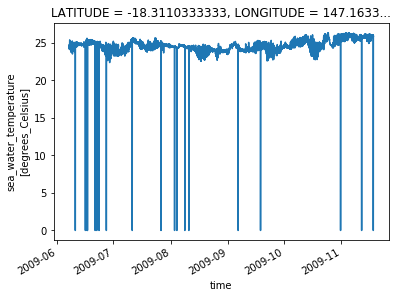

In [36]:
nc.TEMP.plot()

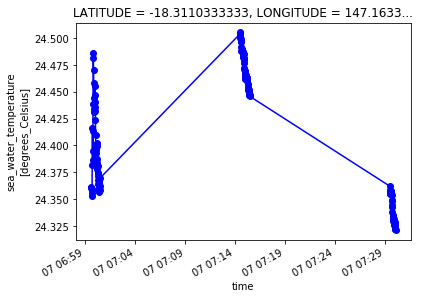

In [56]:
nc.TEMP[100:250].plot.line('b-o')



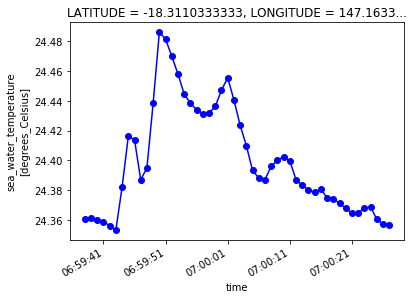

In [57]:
nc.TEMP[100:150].plot.line('b-o')

I'll extract the variable to a pandas data frame and do the resample there:


In [66]:
df = pd.DataFrame({'TIME': nc.TIME, 'TEMP': nc.TEMP, 'TEMPqc': nc.TEMP_quality_control}).set_index('TIME')
df

,TEMP,TEMPqc
TIME,,
2009-06-07 06:30:00.000003328,24.532301,1.0
2009-06-07 06:30:00.999997952,24.535500,1.0
2009-06-07 06:30:02.000002560,24.526100,1.0
2009-06-07 06:30:02.999997184,24.512300,1.0
2009-06-07 06:30:04.000001792,24.493700,1.0
2009-06-07 06:30:04.999996416,24.499001,1.0
2009-06-07 06:30:06.000001024,24.492100,1.0
2009-06-07 06:30:06.999995648,24.522499,1.0
2009-06-07 06:30:08.000000256,24.563400,1.0


In [67]:
df.TEMPqc.value_counts()

1.0    959443
4.0       570
Name: TEMPqc, dtype: int64

In [68]:
df_good = df[df.TEMPqc == 1]

In [70]:
df_good.TEMPqc.value_counts()

1.0    959443
Name: TEMPqc, dtype: int64

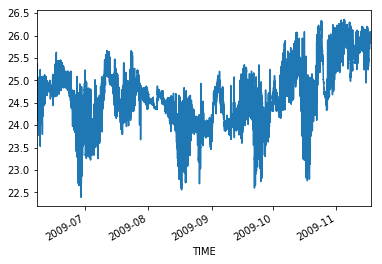

In [73]:
df_good.TEMP.plot()

In [71]:
df_1h = df_good.resample('1H').mean()
df_1h

,TEMP,TEMPqc
TIME,,
2009-06-07 06:00:00,24.434929,1.0
2009-06-07 07:00:00,24.364885,1.0
2009-06-07 08:00:00,24.336782,1.0
2009-06-07 09:00:00,24.510771,1.0
2009-06-07 10:00:00,24.271959,1.0
2009-06-07 11:00:00,24.350267,1.0
2009-06-07 12:00:00,24.612938,1.0
2009-06-07 13:00:00,25.057444,1.0
2009-06-07 14:00:00,25.335222,1.0


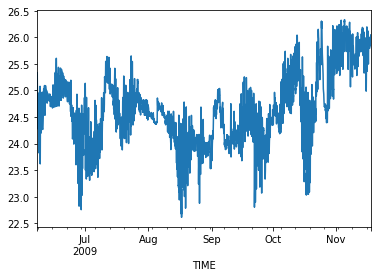

In [72]:
df_1h.TEMP.plot()


## Generic function for the hourly avg

This is a little function that uses:

- a dictionary of binning methods that depends on the variable: mean for electronic sensors (less noisy), median for optical (more noisy)
- a dictionary of additional functions associated to the binning process, as indicators of bin quality: min, max, stdv, count, or any function you want to pass

Also the function move the TIME dimension half an hour back, do the binnning and move the TIME index forward half an hour after.

In [74]:
def PDresample_by_hour(df, function_dict, function_stats):
    """
    resample a dataframe by hour and calculate aggregation statistics
    (mean, std, min, max, count)
    the variables are renamed adding the corresponding suffix of the stats calculated
    from the function_names list

    :param function_stats: list of binning ancillary stat functions
    :param function_dict: dictionary of binning methods to be applied to each variable
    :param df: pandas dataframe with ancillary variables and coords removed but with TIME as index
    :return: pandas dataframe
    """
    ## back the index 30min
    df.index = df.index - pd.Timedelta(30, units='m')

    varnames = df.columns
    df_data = pd.DataFrame()
    for variable in varnames:
        ds_var = df[variable]
        ds_var_mean = ds_var.resample('1H').apply(function_dict[variable]).astype(np.float32)
        df_data = pd.concat([df_data, ds_var_mean], axis=1, sort=False)
        for stat_method in function_stats:
            ds_var_stat = ds_var.resample('1H').apply(stat_method).astype(np.float32)
            ds_var_stat = ds_var_stat.rename("_".join([variable, stat_method]))
            df_data = pd.concat([df_data, ds_var_stat], axis=1, sort=False)

    ##forward the index 30min
    df_data.index = df_data.index + pd.Timedelta(30, units='m')
    return df_data



for example, with our `df_good.TEMP` dataframe:

In [80]:
function_dict = {'TEMP': 'mean'}
function_stats = ['min', 'max', 'std', 'count']

## drop the TEMPqc as we don't want to aggregate this variable
df_1h = PDresample_by_hour(df_good.drop(columns=['TEMPqc']), function_dict, function_stats)
df_1h

,TEMP,TEMP_min,TEMP_max,TEMP_std,TEMP_count
2009-06-07 06:00:00.000000030,24.434929,24.353300,24.567499,0.055196,123.0
2009-06-07 07:00:00.000000030,24.364885,24.254101,24.505199,0.072983,243.0
2009-06-07 08:00:00.000000030,24.336634,24.249901,24.493200,0.056257,245.0
2009-06-07 09:00:00.000000030,24.511635,24.290701,24.750601,0.143976,244.0
2009-06-07 10:00:00.000000030,24.271959,24.168100,24.383200,0.065987,243.0
2009-06-07 11:00:00.000000030,24.350733,24.164400,24.478100,0.077331,245.0
2009-06-07 12:00:00.000000030,24.613544,24.435301,24.913900,0.122583,244.0
2009-06-07 13:00:00.000000030,25.057444,24.740801,25.278601,0.200432,243.0
2009-06-07 14:00:00.000000030,25.335251,25.262501,25.381300,0.034376,245.0
2009-06-07 15:00:00.000000030,25.087021,24.795000,25.367500,0.224282,244.0


*Voilá!*

But this is the simplest case. When integrating several deployments, you need to consider the different depths, so it is not possible to produce a continuous time series over a common time line. Thats why the ragged array structure. See for example this file with 5 deployments of WQM instruments at Palm Passage (QLD)

In [82]:
nc.close()

file = 'data/IMOS_ANMN-QLD_BOSTUZ_20090607_GBRPPS_FV02_hourly-timeseries_END-20101101_C-20191002.nc'
nc = xr.open_dataset(file)
nc

<xarray.Dataset>
Dimensions:           (INSTRUMENT: 5, OBSERVATION: 16730)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] ...
    LONGITUDE         (INSTRUMENT) float64 ...
    LATITUDE          (INSTRUMENT) float64 ...
    NOMINAL_DEPTH     (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    instrument_index  (OBSERVATION) int32 ...
    instrument_id     (INSTRUMENT) |S256 ...
    source_file       (INSTRUMENT) |S256 ...
    DEPTH             (OBSERVATION) float32 ...
    DEPTH_count       (OBSERVATION) float32 ...
    DEPTH_min         (OBSERVATION) float32 ...
    DEPTH_max         (OBSERVATION) float32 ...
    DEPTH_std         (OBSERVATION) float32 ...
    CHLU              (OBSERVATION) float32 ...
    CHLU_count        (OBSERVATION) float32 ...
    CHLU_max          (OBSERVATION) float32 ...
    CHLU_min          (OBSERVATION) float32 ...
    CHLU_std          (OBSERVATION) float32 ...
    CPHL              (OBSER

Note the change in the dimension: INSTRUMENT, OBSERVATION.

If you plot `TEMP` along `TIME` variable, you will have all the instruments mixed together:


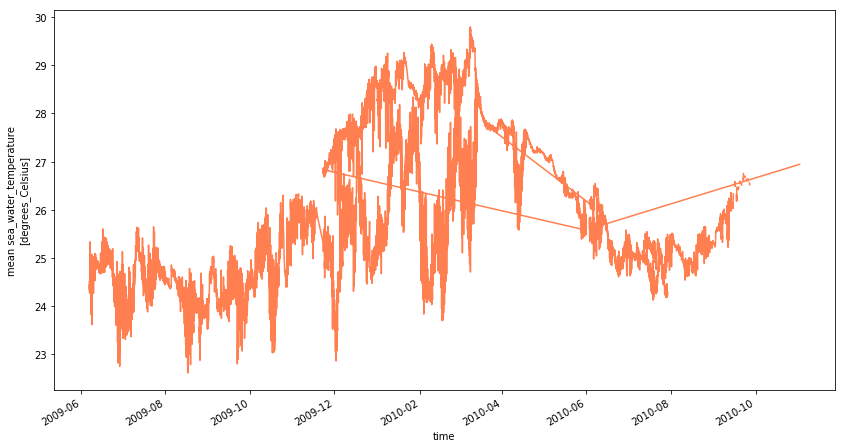

In [112]:
nc.TEMP.plot.line(x='TIME', color='coral', aspect=2, size=7)

As `OBSERVATION` is the only dimension, you need to work the variables as a grouped object.`xarray` and `pandas` work nicely with groups, although pandas is better.

I will convert the nc dataset to a pandas DF. It will result in a multi index dataframe



In [119]:
df = nc.to_dataframe()

df

instrument_index                     instrument_id  \
INSTRUMENT OBSERVATION                                                       
0          0                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           1                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           2                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           3                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           4                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           5                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           6                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           7                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           8                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           9                           0  b'GBRPPS-0906; WETLABS WQM; 046'   
           10                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           11                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           12                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           13                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           14                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           15                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           16                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           17                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           18                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           19                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           20                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           21                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           22                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           23                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           24                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           25                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           26                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           27                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           28                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
           29                          0  b'GBRPPS-0906; WETLABS WQM; 046'   
...                                  ...                               ...   
4          16700                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16701                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16702                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16703                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16704                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16705                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16706                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16707                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16708                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16709                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16710                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16711                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16712                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16713                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16714                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16715                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16716                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16717                       4   b'GBRPPS-1006; WETLABS WQM; 51'   
           16718                       4   b'G

In [ ]:
## create a group object

df_grouped = df.groupby('instrument_index')

Let's have a look at `TEMP`

In [128]:
df_grouped.TEMP.describe()

,count,mean,std,min,25%,50%,75%,max
instrument_index,,,,,,,,
0,19690.0,24.639763,0.682200,22.611076,24.140333,24.589529,25.035639,26.331093
1,22795.0,26.402599,1.113434,22.860884,25.541792,26.529095,27.302622,28.852316
2,14030.0,28.347946,0.669672,25.892708,27.843502,28.509357,28.868782,29.793272
3,12680.0,25.359089,0.457381,24.518503,25.053734,25.258734,25.552837,26.943800
4,6785.0,25.028587,0.411790,24.125105,24.786730,24.990131,25.228212,26.250725


and to the depth. note that `DEPTH` is measured by the instrument, while `NOMINAL_DEPTH` is a global attribute of the file stored as a variable

In [129]:
df_grouped.DEPTH.describe()

,count,mean,std,min,25%,50%,75%,max
instrument_index,,,,,,,,
0,19690.0,50.653419,0.757897,43.168911,50.110344,50.556593,51.142284,53.430084
1,22795.0,56.834377,0.591564,54.627121,56.425407,56.800056,57.237820,58.964642
2,14030.0,13.070544,0.997563,11.217538,12.436622,12.901709,13.495402,20.261929
3,12680.0,14.348653,0.786520,12.757843,13.837494,14.246210,14.713037,18.622822
4,6785.0,58.424305,0.541742,57.103725,58.073338,58.401218,58.747112,59.825359


In [130]:
df_grouped.NOMINAL_DEPTH.describe()

,count,mean,std,min,25%,50%,75%,max
instrument_index,,,,,,,,
0,19690.0,39.099998,20.069710,14.0,15.5,50.5,57.0,58.5
1,22795.0,39.099998,20.068443,14.0,15.5,50.5,57.0,58.5
2,14030.0,39.099998,20.069983,14.0,15.5,50.5,57.0,58.5
3,18205.0,39.099998,20.069765,14.0,15.5,50.5,57.0,58.5
4,8930.0,39.099998,20.069153,14.0,15.5,50.5,57.0,58.5


instrument_index
0    [AxesSubplot(0.125,0.2;0.775x0.68)]
1    [AxesSubplot(0.125,0.2;0.775x0.68)]
2    [AxesSubplot(0.125,0.2;0.775x0.68)]
3    [AxesSubplot(0.125,0.2;0.775x0.68)]
4    [AxesSubplot(0.125,0.2;0.775x0.68)]
dtype: object

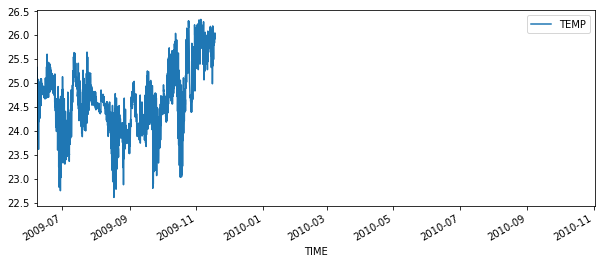

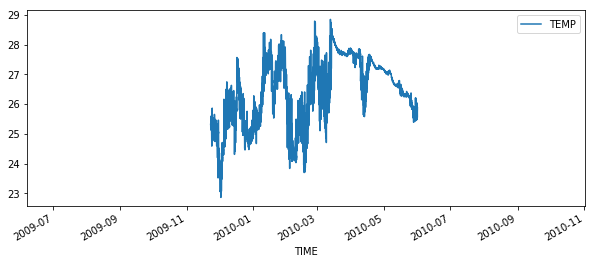

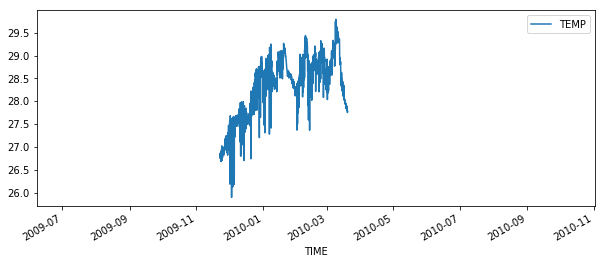

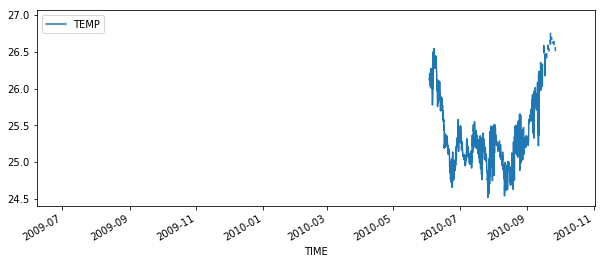

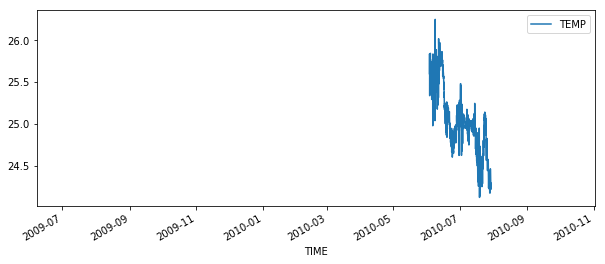

In [142]:


## get the time min and max to have a common x axis
TIMEmin = df['TIME'].min()
TIMEmax = df['TIME'].max()

df_grouped.plot(x='TIME', y='TEMP', kind='line', subplots=True, 
                xlim=(TIMEmin, TIMEmax), figsize=(10,4))


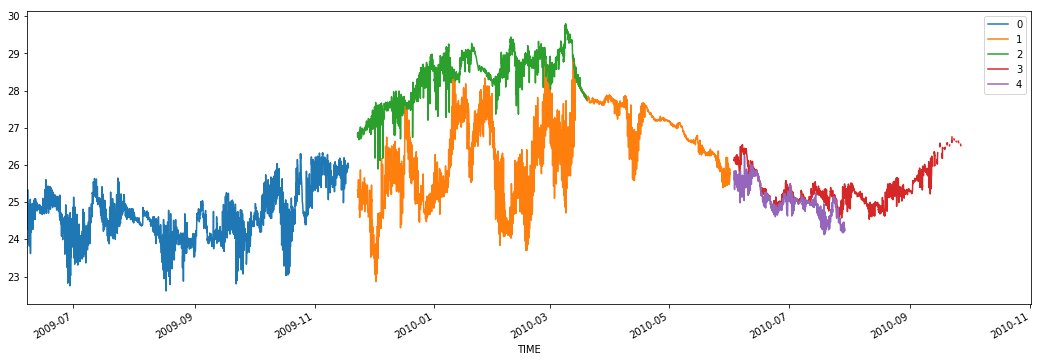

In [144]:
fig, ax = plt.subplots(figsize=(18,6))

for name, group in df_grouped:
    group.plot(x='TIME', y='TEMP', ax=ax, label=name)

plt.show()

All the scripts are available in https://github.com/aodn/python-aodntools/tree/master/aodntools/timeseries_products

The product series will include: 

1. Aggregated time series: **ONE** variable from **ALL** instruments at **ONE** site 
2. Hourly time series: **ALL** variables from **ALL** instruments at **ONE** site, binned to **1hr fixed interval**
3. Gridded time series: **ONE** variable from **ALL** instruments at **ONE** sites binned to **1hr bins and 1m depth bins** (more for the deep water moorings)

and they will be developed for non-velocity variables (1D), velocity variables (2D), and Profiles.